In [1]:
from typing import List, Optional, Tuple, Union

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from score_analysis import showbias

## Create some toy data

In its simplest case, the showbias function assumes that you have a pandas dataframe with three columns:
- a `group` column that indicates group membership for every row, e.g. female and male values in a column called gender
- a `scores` column that contains the predicted scores (e.g. by a model) for
- a `labels` column that contains the ground truth using integers

Below we create a synthetic dataset that contains dogfido<b><sup>TM</sup></b> IDV data for different dog breeds

In [2]:
df = pd.DataFrame({
    'breed': np.random.choice(['Labrador Retriever', 'German Shepherd', 'Golden Retriever', 'Bulldog', 'Beagle'], size=1000),
    'labels': np.random.choice([0, 1], size=1000),
    'scores': np.linspace(0.0, 1.0, 1000)
})

In [3]:
df.head()

,breed,labels,scores
0,Beagle,0,0.000000
1,German Shepherd,1,0.001001
2,Bulldog,0,0.002002
3,Beagle,1,0.003003
4,Golden Retriever,1,0.004004


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Beagle'),
  Text(1, 0, 'German Shepherd'),
  Text(2, 0, 'Bulldog'),
  Text(3, 0, 'Golden Retriever'),
  Text(4, 0, 'Labrador Retriever')])

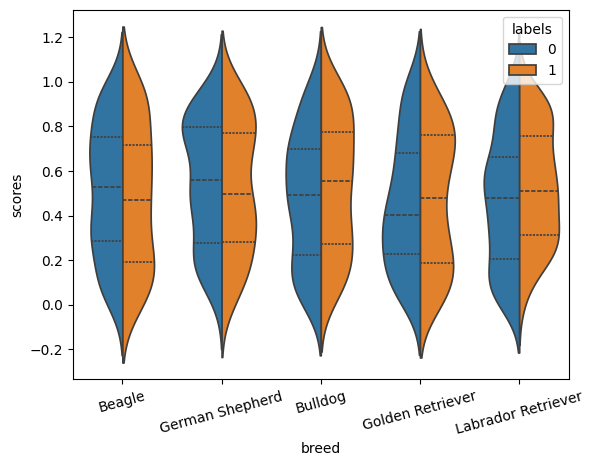

In [4]:
sns.violinplot(data=df, x="breed", y="scores", hue="labels", split=True, inner="quart")
plt.xticks(rotation=15)

## Showbias vanilla version

In [5]:
bias_frame = showbias(data=df, group_columns="breed", label_column="labels", score_column="scores", metric="fnr", threshold=[0.5])

In [6]:
print(bias_frame.to_markdown())

| breed              |   0.5 |
|:-------------------|------:|
| Beagle             | 0.543 |
| Bulldog            | 0.444 |
| German Shepherd    | 0.505 |
| Golden Retriever   | 0.515 |
| Labrador Retriever | 0.47  |


## Passing several thresholds at once

In [7]:
bias_frame = showbias(data=df, group_columns="breed", label_column="labels", score_column="scores", metric="fnr", threshold=[0.3, 0.5, 0.7])
print(bias_frame.to_markdown())

| breed              |   0.3 |   0.5 |   0.7 |
|:-------------------|------:|------:|------:|
| Beagle             | 0.37  | 0.543 | 0.716 |
| Bulldog            | 0.284 | 0.444 | 0.654 |
| German Shepherd    | 0.258 | 0.505 | 0.656 |
| Golden Retriever   | 0.347 | 0.515 | 0.713 |
| Labrador Retriever | 0.231 | 0.47  | 0.701 |


## Normalising metric

You can obtain metrics that are normalised to the metric measured across the entire dataset by passing the `normalize` argument, like so:

In [8]:
bias_frame = showbias(data=df, group_columns="breed", label_column="labels", score_column="scores", metric="fnr", threshold=[0.5], normalize="by_overall")
print(bias_frame.to_markdown())

| breed              |   0.5 |
|:-------------------|------:|
| Beagle             | 1.098 |
| Bulldog            | 0.898 |
| German Shepherd    | 1.022 |
| Golden Retriever   | 1.041 |
| Labrador Retriever | 0.95  |


## What is a BiasFrame?

In [9]:
type(bias_frame)

score_analysis.showbias.BiasFrame

In [10]:
print(bias_frame)

BiasFrame(values=                         0.5
breed                       
Beagle              1.098027
Bulldog             0.898386
German Shepherd     1.021551
Golden Retriever    1.040704
Labrador Retriever  0.950216, alpha=None, lower=None, upper=None)


In [11]:
type(bias_frame.values)

pandas.core.frame.DataFrame

## Confidence intervals

You can obtain confidence intervals by setting the `bootstrap_ci` to `True`:

In [12]:
from score_analysis import BootstrapConfig

bootstrap_config = BootstrapConfig(nb_samples=500, bootstrap_method="quantile")
bias_frame = showbias(data=df, group_columns="breed", label_column="labels", score_column="scores", metric="fnr", threshold=[0.5], bootstrap_ci=True, bootstrap_config=bootstrap_config)

In [13]:
print(bias_frame)

BiasFrame(values=                         0.5
breed                       
Beagle              0.543210
Bulldog             0.444444
German Shepherd     0.505376
Golden Retriever    0.514851
Labrador Retriever  0.470085, alpha=0.05, lower=                         0.5
breed                       
Beagle              0.440000
Bulldog             0.343235
German Shepherd     0.403034
Golden Retriever    0.417087
Labrador Retriever  0.380731, upper=                         0.5
breed                       
Beagle              0.657895
Bulldog             0.551994
German Shepherd     0.607190
Golden Retriever    0.604421
Labrador Retriever  0.562500)


In [14]:
print(bias_frame.to_markdown())

| breed              | 0.5             |
|:-------------------|:----------------|
| Beagle             | 0.543           |
|                    | (0.44 - 0.658)  |
| Bulldog            | 0.444           |
|                    | (0.343 - 0.552) |
| German Shepherd    | 0.505           |
|                    | (0.403 - 0.607) |
| Golden Retriever   | 0.515           |
|                    | (0.417 - 0.604) |
| Labrador Retriever | 0.47            |
|                    | (0.381 - 0.562) |


## Multiple protected characteristics

In [15]:
df_multiple = pd.DataFrame({
    'breed': np.random.choice(['Labrador Retriever', 'German Shepherd', 'Golden Retriever', 'Bulldog', 'Beagle'], size=1000),
    'gender': np.random.choice(['female', 'male'], size=1000),
    'labels': np.random.choice([0, 1], size=1000),
    'scores': np.linspace(0.0, 1.0, 1000)
})

In [16]:
bias_frame_multiple = showbias(data=df_multiple, group_columns=["breed", "gender"], label_column="labels", score_column="scores", metric="fnr", threshold=[0.3, 0.5])
print(bias_frame_multiple.to_markdown())

|                                  |   0.3 |   0.5 |
|:---------------------------------|------:|------:|
| ('Beagle', 'female')             | 0.222 | 0.407 |
| ('Beagle', 'male')               | 0.379 | 0.5   |
| ('Bulldog', 'female')            | 0.214 | 0.381 |
| ('Bulldog', 'male')              | 0.314 | 0.471 |
| ('German Shepherd', 'female')    | 0.217 | 0.435 |
| ('German Shepherd', 'male')      | 0.302 | 0.488 |
| ('Golden Retriever', 'female')   | 0.333 | 0.549 |
| ('Golden Retriever', 'male')     | 0.235 | 0.49  |
| ('Labrador Retriever', 'female') | 0.34  | 0.52  |
| ('Labrador Retriever', 'male')   | 0.333 | 0.464 |


## BiasFrame methods

### to_markdown()

In [17]:
bias_frame_multiple_md = bias_frame_multiple.to_markdown(reset_display_index=True, number_decimal_points=5)
print(bias_frame_multiple_md)

| breed              | gender   |     0.3 |     0.5 |
|:-------------------|:---------|--------:|--------:|
| Beagle             | female   | 0.22222 | 0.40741 |
| Beagle             | male     | 0.37931 | 0.5     |
| Bulldog            | female   | 0.21429 | 0.38095 |
| Bulldog            | male     | 0.31373 | 0.47059 |
| German Shepherd    | female   | 0.21739 | 0.43478 |
| German Shepherd    | male     | 0.30233 | 0.48837 |
| Golden Retriever   | female   | 0.33333 | 0.54902 |
| Golden Retriever   | male     | 0.23529 | 0.4902  |
| Labrador Retriever | female   | 0.34    | 0.52    |
| Labrador Retriever | male     | 0.33333 | 0.46377 |


## Plotting functionality

In [18]:
from score_analysis.showbias_plotting import plot_single_threshold, plot_multiple_thresholds

### plot_single_threshold

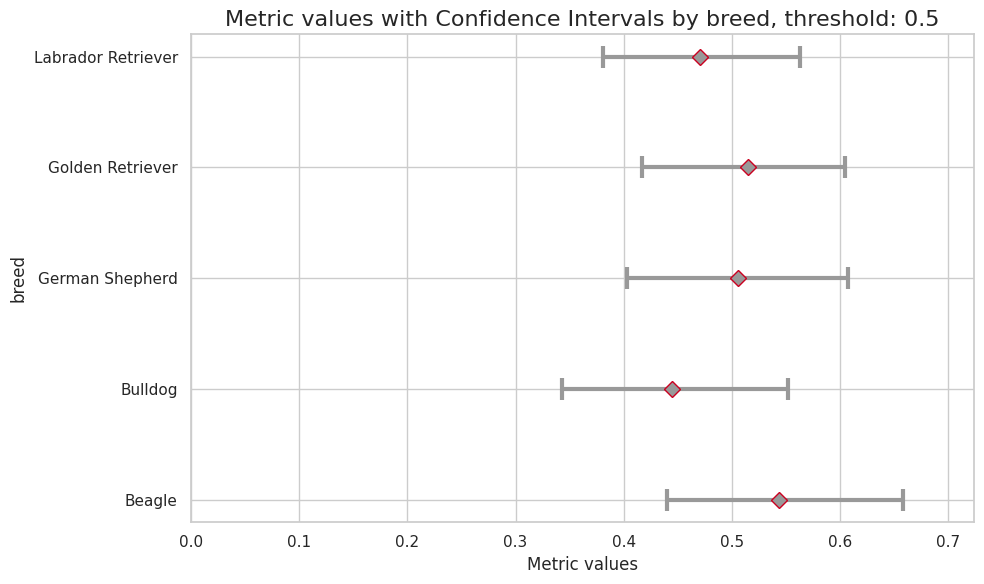

In [19]:
plot = plot_single_threshold(bias_frame, threshold=0.5)
plot.show()

### plot_multiple_thresholds

In [20]:
thresholds = np.linspace(0.0, 1.0, 1000)
bias_frame = showbias(data=df, group_columns="breed", label_column="labels", score_column="scores", metric="fnr", threshold=thresholds.tolist())

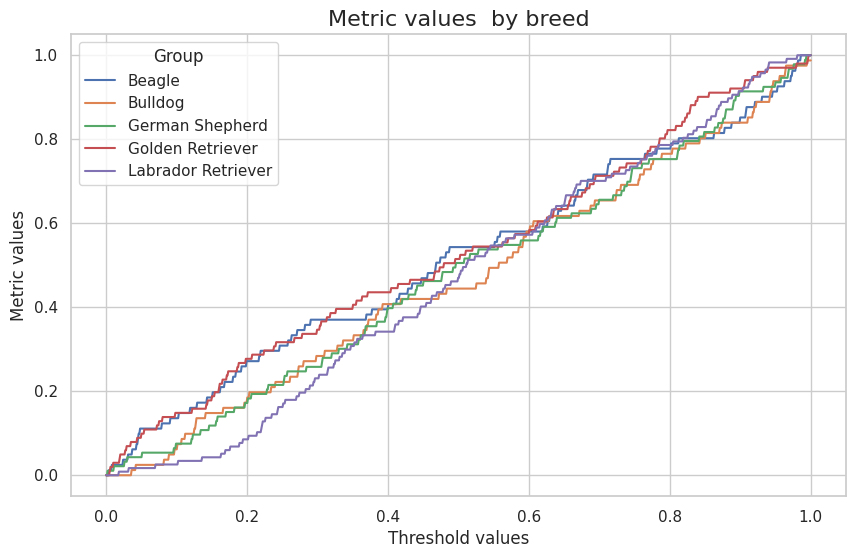

In [21]:
plot = plot_multiple_thresholds(bias_frame)
plot.show()

## Available metrics

`showbias` supports all metrics that are supported by `score-analysis`.
Currently, you can pass any of the strings below to the metric argument in showbias:

Basic parameters:
- "tp" (true positive)
- "tn" (true negative)
- "fp" (false positive)
- "fn" (false negative)
- "p" (condition positive)
- "n" (condition negative)
- "top" (test outcome positive)
- "ton" (test outcome negative)
- "pop" (population counts)

Class metrics
- "tpr" (true positive rate)
- "tnr" (true negative rate)
- "fpr" (false positive rate)
- "fnr" (false negative rate)
- "topr" (test outcome positive rate)
- "tonr" (test outcome negative rate)
- "ppv" (positive predictive value)
- "npv" (negative predictive value)
- "fdr" (false discovery rate)
- "for_" (false omission rate)
- "class_accuracy" (class accuracy)
- "class_error_rate" (class_error_rate)

Overall metrics
- "accuracy" (Accuracy)
- "error_rate" (Error rate)